<a href="https://colab.research.google.com/github/michaelgodoyf/tareas-proc-digi-multimedia/blob/main/Proyecto_2_ApellidoNombre_ID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA
</center></font>


<center><h2>Proyecto 2</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por:Michael Godoy Ferreira</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>


In [ ]:
from IPython.display import IFrame, display
#filepath = "Proyecto_2_EIE401.pdf"
#IFrame(filepath, width=700, height=400)

En la dirección https://huggingface.co/datasets/astroboy1/metasurfaces_V1_30-90GHZ encontrarás el archivo batch_june2024.zip que contiene las imagenes que usarás para el procesamiento. ATENCION: usa el archivo zip indicado pues tienes las imagenes preparadas para tu trabajo.

## 1. Carga de Datos


- En los archivos, encontrarás un folder con imagenes de 3 categorías: cross, box, circle.
Cada imagen tiene una medida de 512x512 pixeles y 3 canales. Se han acentuado los azules y rojos para facilitar el proceso de obtención de características.

- Puedes extraer la clase a la que pertenece la imagen, desde el nombre del archivo. Ahí mismo encuentras números de serie que te permiten identificar de forma específica una imagen.

- Se te entrega 3 imagenes de referencia de 32x32 pixeles, las que debes usar como plantilla para el proceso de clasificación de la imagen.


In [1]:
!git clone https://github.com/Jorgecardenas1/EIE_401_MULTIMEDIA.git

Cloning into 'EIE_401_MULTIMEDIA'...
remote: Enumerating objects: 347, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 347 (delta 1), reused 1 (delta 0), pack-reused 341
Receiving objects: 100% (347/347), 44.47 MiB | 13.26 MiB/s, done.
Resolving deltas: 100% (159/159), done.


Downloading...
From (original): https://drive.google.com/uc?id=1H64kBm3Fnd_UyH4IUFKxrR0pHscli7Lr
From (redirected): https://drive.google.com/uc?id=1H64kBm3Fnd_UyH4IUFKxrR0pHscli7Lr&confirm=t&uuid=ca43133f-3528-46b4-b59d-544f41c31991
To: /content/batch_june2024.zip
100%|██████████| 39.0M/39.0M [00:00<00:00, 109MB/s]


Total de archivos extraídos: 14328


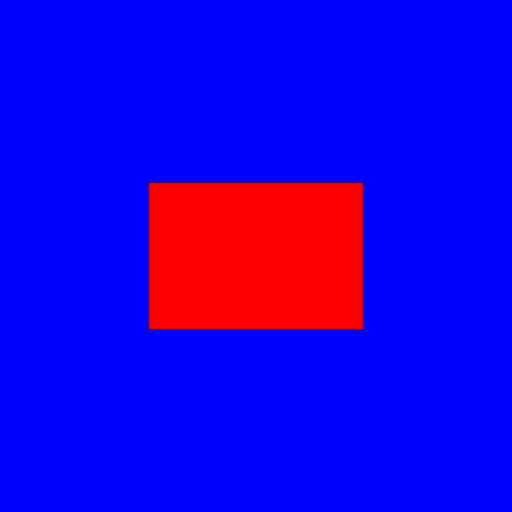

In [24]:
import os
import zipfile
import shutil
import gdown
import multiprocessing
import cv2
from google.colab.patches import cv2_imshow  # Importa cv2_imshow para mostrar imágenes en Colab

# Verificar si gdown está instalado
try:
    import gdown
except ImportError:
    os.system('pip install gdown')

# URL del archivo en Google Drive
url = 'https://drive.google.com/uc?id=1H64kBm3Fnd_UyH4IUFKxrR0pHscli7Lr'

# Ruta donde se guardará el archivo ZIP descargado
ruta_archivo_zip = 'batch_june2024.zip'

# Descargar el archivo ZIP desde Google Drive
gdown.download(url, ruta_archivo_zip, quiet=False)

# Directorio donde se descomprimirán las imágenes
directorio_extraccion = 'imagenes_extraidas'
os.makedirs(directorio_extraccion, exist_ok=True)

# Directorio donde se moverán las imágenes después de procesarlas
directorio_final_imagenes = 'imagenes_finales'
os.makedirs(directorio_final_imagenes, exist_ok=True)

# Función para mover archivos
def mover_archivo(nombre_archivo):
    shutil.move(os.path.join(directorio_extraccion, 'processed512', nombre_archivo), os.path.join(directorio_final_imagenes, nombre_archivo))

# Descomprimir el archivo ZIP
with zipfile.ZipFile(ruta_archivo_zip, 'r') as zip_ref:
    zip_ref.extractall(directorio_extraccion)

# Escanear el directorio para verificar archivos extraídos
with os.scandir(os.path.join(directorio_extraccion, 'processed512')) as entradas:
    archivos_extraidos = [entrada.name for entrada in entradas if entrada.is_file() and entrada.name.endswith('.png')]

print(f'Total de archivos extraídos: {len(archivos_extraidos)}')


# Mover imágenes al directorio final usando multiprocessing
with multiprocessing.Pool() as pool:
    pool.map(mover_archivo, archivos_extraidos)

# Mostrar una de las imágenes cargadas
if len(os.listdir(directorio_final_imagenes)) > 0:
    # Selecciona una imagen para mostrar (por ejemplo, la primera de la lista)
    ruta_imagen_mostrar = os.path.join(directorio_final_imagenes, archivos_extraidos[0])

    # Lee la imagen usando OpenCV
    imagen_mostrar = cv2.imread(ruta_imagen_mostrar)

    # Muestra la imagen usando cv2_imshow en lugar de cv2.imshow
    cv2_imshow(imagen_mostrar)
else:
    print('No se encontraron imágenes en el directorio final.')

# Eliminar archivos temporales
os.remove(ruta_archivo_zip)
shutil.rmtree(directorio_extraccion)




## 2. Transformar imagen
Recuerda que la tarea es lograr el procesamiento más rápido posible.
Para lograr esto, realiza las operaciones que consideres necesarias sobre la imagen original para el posterior trabajo de Matching con las plantillas dadas. Crees que trabajar en el dominio de fourier o wavelet ayudaría en las etapas posteriores?

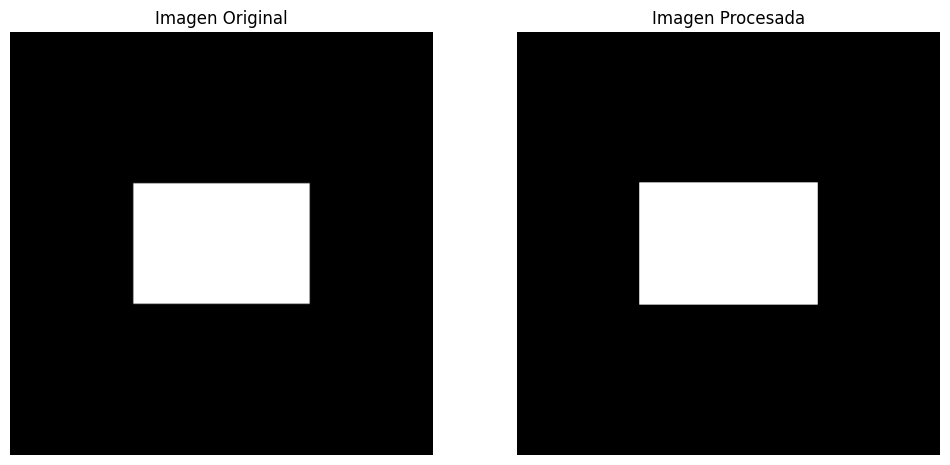

In [19]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import multiprocessing

# Ruta del directorio que contiene las imágenes
directorio_imagenes = '/content/imagenes_listas'

# Obtengo la lista de archivos de imágenes en el directorio
archivos_imagenes = [os.path.join(directorio_imagenes, f) for f in os.listdir(directorio_imagenes) if f.endswith('.png') or f.endswith('.jpg')]

# Crear un directorio para guardar las imágenes procesadas
directorio_imagenes_procesadas = '/content/imagenes_procesadas'
os.makedirs(directorio_imagenes_procesadas, exist_ok=True)

# Función para aplicar las transformaciones a una imagen
def aplicar_transformaciones(ruta_imagen):
    # Cargo la imagen en escala de grises
    img = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)

    # Ajusto  el contraste y brillo
    alpha = 1.0  # Factor de contraste
    beta = 30    # Valor de brillo
    img_ajustada = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

    # Binarización de la imagen
    _, img_binaria = cv2.threshold(img_ajustada, 59, 255, cv2.THRESH_BINARY)

    # Guarda la imagen procesada
    nueva_ruta_imagen = os.path.join(directorio_imagenes_procesadas, f'procesada_{os.path.basename(ruta_imagen)}')
    cv2.imwrite(nueva_ruta_imagen, img_binaria)

    return nueva_ruta_imagen

# Procesar todas las imágenes en paralelo
with multiprocessing.Pool() as pool:
    rutas_imagenes_procesadas = pool.map(aplicar_transformaciones, archivos_imagenes)

# Mostro una imagen original y su versión procesada
ruta_imagen_muestra = archivos_imagenes[0]
ruta_imagen_procesada_muestra = os.path.join(directorio_imagenes_procesadas, f'procesada_{os.path.basename(ruta_imagen_muestra)}')

# Cargo las imágenes
img_original = cv2.imread(ruta_imagen_muestra, cv2.IMREAD_GRAYSCALE)
img_procesada = cv2.imread(ruta_imagen_procesada_muestra, cv2.IMREAD_GRAYSCALE)

# Muestrp las imágenes
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_original, cmap='gray')
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_procesada, cmap='gray')
plt.title('Imagen Procesada')
plt.axis('off')

plt.show()


<ipython-input-20-e89b719b8ed9>:24: RuntimeWarning: divide by zero encountered in log
  espectro_magnitud = 20 * np.log(np.abs(transformada_shift))


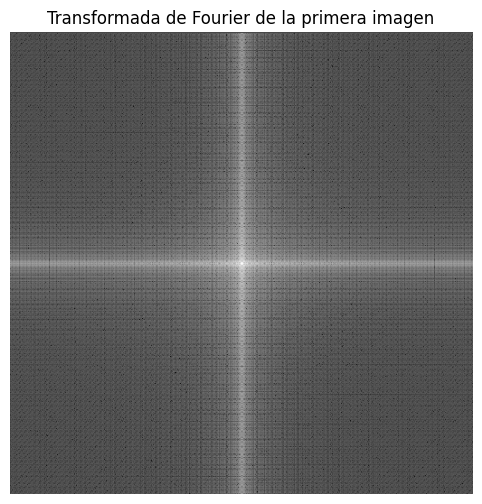

Se procesaron 28656 imágenes con la transformada de Fourier.


In [20]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Ruta del directorio que contiene las imágenes originales
directorio_imagenes = '/content/imagenes_procesadas'

# Obtengo la lista de archivos de imágenes en el directorio
archivos_imagenes = [os.path.join(directorio_imagenes, f) for f in os.listdir(directorio_imagenes) if f.endswith('.png') or f.endswith('.jpg')]

# Creo un directorio para guardar las imágenes procesadas con Fourier
directorio_fourier = '/content/fourier_imagenes'
os.makedirs(directorio_fourier, exist_ok=True)

# Función para aplicar la transformada de Fourier a una imagen binarizada
def aplicar_transformada_fourier(ruta_imagen):
    # Cargar la imagen binarizada en escala de grises
    img_binaria = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)

    # Calcular la transformada de Fourier
    transformada_f = np.fft.fft2(img_binaria)
    transformada_shift = np.fft.fftshift(transformada_f)
    espectro_magnitud = 20 * np.log(np.abs(transformada_shift))

    return espectro_magnitud

# Proceso todas las imágenes y guardarlas con un nuevo nombre en el directorio fourier_imagenes
contador_procesadas = 0
for ruta_imagen in archivos_imagenes:
    # Aplico transformada de Fourier
    imagen_fourier = aplicar_transformada_fourier(ruta_imagen)



    contador_procesadas += 1

# Muestro la transformada de Fourier de la primera imagen para verificar
ruta_ejemplo = archivos_imagenes[0]
plt.figure(figsize=(12, 6))
plt.imshow(aplicar_transformada_fourier(ruta_ejemplo), cmap='gray')
plt.title('Transformada de Fourier de la primera imagen')
plt.axis('off')
plt.show()

# Muestro el total de imágenes procesadas con Fourier
print(f'Se procesaron {contador_procesadas} imágenes con la transformada de Fourier.')



## 3. Operaciones
Para extraer las caracteristicas, debes realizar las operaciones de segmentación, normalización o convolución como creas necesarias.
El resultado de tus operaciones vas a usarlo para el proceso de matching.


In [6]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

# Rutas de las imágenes template
template_paths = [
    '/content/EIE_401_MULTIMEDIA/Proyectos/Proyecto 2/box_templae.png',
    '/content/EIE_401_MULTIMEDIA/Proyectos/Proyecto 2/circ_templae.png',
    '/content/EIE_401_MULTIMEDIA/Proyectos/Proyecto 2/cross_templae.png'
]

# Listas para almacenar los kernels y las imágenes template
kernels = []
templates = []

# Función para cargar imágenes y crear kernels
def load_templates_and_kernels():
    for path in template_paths:
        # Carga la imagen template
        template = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        templates.append(template)

        # Binarizo la imagen template
        _, template_bin = cv2.threshold(template, 59, 255, cv2.THRESH_BINARY)

        # Creo un kernel a partir de la imagen binarizada
        kernel = np.float32(template_bin)
        kernels.append(kernel)

# Cargo las imágenes template y definir los kernels
load_templates_and_kernels()

# Muestro los kernels creados
for i, kernel in enumerate(kernels):
    cv2_imshow(kernel)



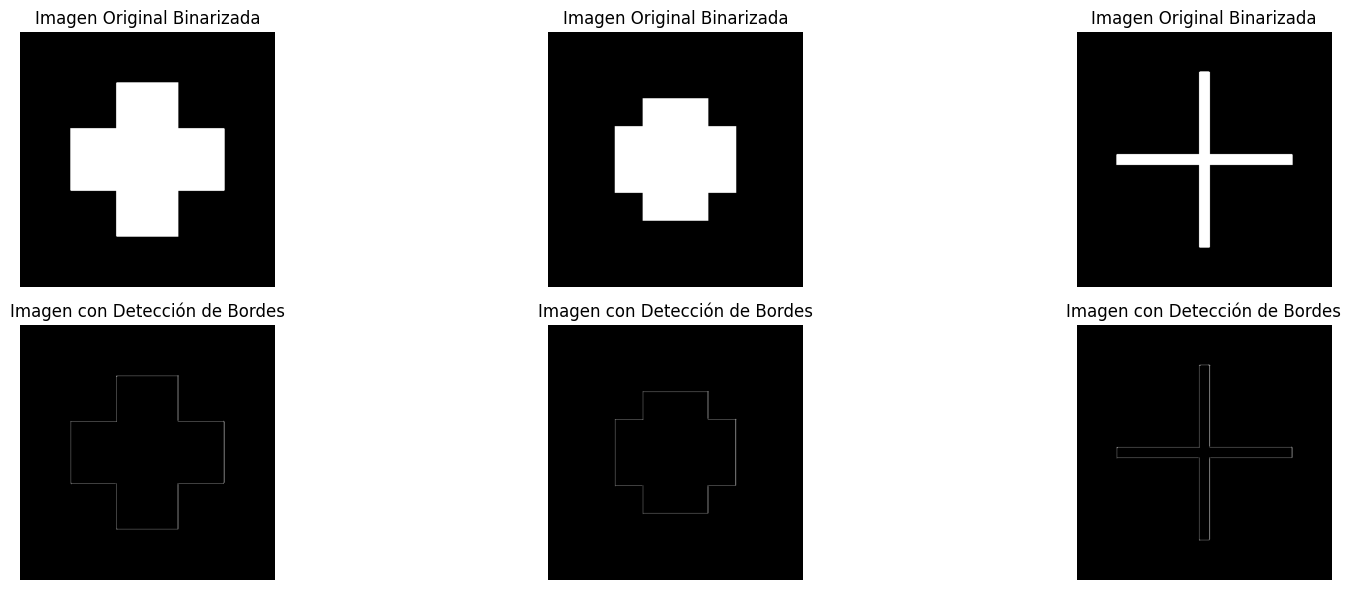

Se procesaron 28656 imágenes con detección de bordes.
Se guardaron las características de las imágenes en caracteristicas_bordes.npy.


In [21]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random

# Ruta del directorio que contiene las imágenes binarizadas
directorio_imagenes = '/content/imagenes_procesadas'

# Obtengo la lista de archivos de imágenes en el directorio
archivos_imagenes = [os.path.join(directorio_imagenes, f) for f in os.listdir(directorio_imagenes) if f.endswith('.png')]

# Creo un directorio para guardar las imágenes procesadas con detección de bordes
directorio_imagenes_bordes = '/content/imagenes_bordes'
os.makedirs(directorio_imagenes_bordes, exist_ok=True)

# Defino el kernel de detección de bordes Sobel ajustado
kernel_sobel_x = np.array([[-1, 1, 0],
                           [0, 1, 0],
                           [-1, 1, -1]], dtype=np.float32)

kernel_sobel_y = np.array([[-1, -1, -1],
                           [1, 1, 1],
                           [0, 1, -1]], dtype=np.float32)

# Función para aplicar detección de bordes a una imagen binarizada y extraer características
def extraer_caracteristicas_bordes(ruta_imagen, kernel_x, kernel_y):
    # Cargo la imagen binarizada
    img_binaria = cv2.imread(ruta_imagen, cv2.IMREAD_UNCHANGED)  # Se carga como está (binarizada)

    # Aplico reflexión de píxeles para evitar cortes en los bordes
    img_reflect = cv2.copyMakeBorder(img_binaria, 1, 1, 1, 1, cv2.BORDER_REFLECT)

    # Aplico convolución usando Sobel para detectar bordes en ambas direcciones
    bordes_x = cv2.filter2D(img_reflect, -1, kernel_x)
    bordes_y = cv2.filter2D(img_reflect, -1, kernel_y)

    # Combino las detecciones de bordes en una imagen final
    img_bordes = cv2.addWeighted(bordes_x, 0.5, bordes_y, 0.5, 0)

    # Extraigo características de la imagen con detección de bordes y convertirlas a float32
    caracteristicas = np.array(img_bordes, dtype=np.float32).flatten()

    # Guardo la imagen procesada con detección de bordes
    ruta_imagen_bordes = os.path.join(directorio_imagenes_bordes, f'bordes_{os.path.basename(ruta_imagen)}')
    cv2.imwrite(ruta_imagen_bordes, np.uint8(img_bordes))

    # Liberar memoria de variables temporales
    del img_binaria, img_reflect, bordes_x, bordes_y, img_bordes

    return caracteristicas

# Proceso todas las imágenes y extraer características, guardándolas en variables
contador_procesadas = 0

#  para almacenar características de imágenes
diccionario_caracteristicas = {}

for ruta_imagen in archivos_imagenes:
    # Extraigo características de la imagen con detección de bordes
    caracteristicas = extraer_caracteristicas_bordes(ruta_imagen, kernel_sobel_x, kernel_sobel_y)

    # Guardo las características en un diccionario usando el nombre base de la imagen como clave
    nombre_imagen = os.path.basename(ruta_imagen)
    diccionario_caracteristicas[nombre_imagen] = caracteristicas

    contador_procesadas += 1

    # Libero memoria del diccionario de características cada 1000 imágenes procesadas
    if contador_procesadas % 1000 == 0:
        diccionario_caracteristicas = {}

# Muestro la primera, última y una imagen aleatoria original y su versión con detección de bordes para verificar
muestras_rutas_imagenes = [
    archivos_imagenes[0],  # Primera imagen
    archivos_imagenes[-1],  # Última imagen
    archivos_imagenes[random.randint(0, len(archivos_imagenes) - 1)]  # Imagen aleatoria
]

plt.figure(figsize=(18, 6))
for i, ruta_imagen_muestra in enumerate(muestras_rutas_imagenes):
    ruta_imagen_bordes = os.path.join(directorio_imagenes_bordes, f'bordes_{os.path.basename(ruta_imagen_muestra)}')

    plt.subplot(2, 3, i + 1)
    plt.imshow(cv2.imread(ruta_imagen_muestra, cv2.IMREAD_UNCHANGED), cmap='gray')
    plt.title('Imagen Original Binarizada')
    plt.axis('off')

    plt.subplot(2, 3, i + 4)
    plt.imshow(cv2.imread(ruta_imagen_bordes, cv2.IMREAD_UNCHANGED), cmap='gray')
    plt.title('Imagen con Detección de Bordes')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Muestro total de imágenes procesadas con detección de bordes
print(f'Se procesaron {contador_procesadas} imágenes con detección de bordes.')

# Guardo las características en un archivo npy para uso posterior
np.save('/content/caracteristicas_bordes.npy', diccionario_caracteristicas)
print(f'Se guardaron las características de las imágenes en caracteristicas_bordes.npy.')



## 4. Matching
El proceso de matching debe considerar que vas a usar las imagenes de referencia para calcular la correlación


Este proceso es similar a un windowing, donde la ventana es la imagen de referencia.
Como verás es un proceso iterativo, dispendioso, pero en el que puedes poner tu creatividad a funcionar para lograrlo de forma eficiente.

#### _TIP: realiza el proceso un batch pequeño de imagenes, o solo sobre un par de ellas, hasta que estés satisfecho con el resultado. Una vez esté listo, ESCALA el procedimiento para operar todas la imagenes lo más rápido posible.!_

In [14]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random

# Rutas de las imágenes template
template_paths = [
    '/content/EIE_401_MULTIMEDIA/Proyectos/Proyecto 2/box_templae.png',
    '/content/EIE_401_MULTIMEDIA/Proyectos/Proyecto 2/circ_templae.png',
    '/content/EIE_401_MULTIMEDIA/Proyectos/Proyecto 2/cross_templae.png'
]

# Ruta del archivo npy con las características de bordes
features_file = '/content/caracteristicas_bordes.npy'

# Cargo las características de las imágenes procesadas
features_dict = np.load(features_file, allow_pickle=True).item()

# Cargo las imágenes template
templates = []
for path in template_paths:
    template = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if template is None:
        raise ValueError(f'No se pudo cargar la imagen template en: {path}')
    templates.append(template.astype(np.float32))  # Convertir a np.float32

# Función para realizar el matching usando correlación cruzada
def perform_matching(features_dict, templates):
    results = []

    for image_name, features in features_dict.items():
        max_corr = -1
        predicted_class = None

        # Convierto las características a formato adecuado para comparación
        features_array = np.array(features, dtype=np.float32).reshape(1, -1)

        # Realizo la correlación cruzada con cada template
        for i, template in enumerate(templates):
            result = cv2.matchTemplate(features_array, template.reshape(1, -1), cv2.TM_CCORR_NORMED)
            correlation = result[0, 0]

            # Guardo la correlación más alta y la clase predicha
            if correlation > max_corr:
                max_corr = correlation
                predicted_class = i  # Uso el índice como clase (0, 1, 2)

        results.append((image_name, predicted_class, max_corr))

    return results

# Realizo el matching con las características cargadas y los templates
matching_results = perform_matching(features_dict, templates)

# Muestro los resultados
for result in matching_results:
    print(f'Imagen: {result[0]}, Clase Predicha: {result[1]}, Correlación: {result[2]}')



Imagen: processed_circ_01_freq_reflect_bd00bd23-e53b-11ee-a555-047c16a08772_0-954_80-90.png, Clase Predicha: 0, Correlación: 0.0
Imagen: processed_cross_01_freq_reflect_7357cade-0e1a-11ef-859e-047c16a08772_0-99_80-90.png, Clase Predicha: 0, Correlación: 0.0
Imagen: processed_cross_01_freq_reflect_3be7fd33-bd16-11ee-be43-047c16a08772_0-553_80-90.png, Clase Predicha: 0, Correlación: 0.0
Imagen: processed_cross_01_freq_reflect_e9503ad7-c681-11ee-809f-047c16a08772_0-266_80-90.png, Clase Predicha: 0, Correlación: 0.0
Imagen: processed_cross_01_freq_reflect_b1de6052-eca2-11ee-9194-047c16a08772_0-677_80-90.png, Clase Predicha: 0, Correlación: 0.0
Imagen: processed_cross_01_freq_reflect_e9503ad7-c681-11ee-809f-047c16a08772_0-214_80-90.png, Clase Predicha: 0, Correlación: 0.0
Imagen: processed_cross_01_freq_reflect_3bb122d5-e627-11ee-9e43-a4c3f0508c4a_0-123_80-90.png, Clase Predicha: 0, Correlación: 0.0
Imagen: processed_circ_01_freq_reflect_56dee422-b317-11ee-bb58-047c16a08772_0-1245_80-90.png

# 5. Clasificación
De cada operación realizada de matching, obtendrás valores para inferir si la imagen bajo estudio corresponde con alguna de las 3 categorías: cross, box, circle.

Debes almacenar cada resultado obtenido para cada imagen, hallar el error de clasificación y generar un informe del error general al clasificar todas las imagenes.

Presenta aquí el resultado de clasificación numérico, así como  dos ejemplos verdaderos y dos ejemplos falsos de imagenes clasificadas.


# 6. Medición
Recuerda que debes imprimir el tiempo que tarda tu algoritmo en procesar todas las imagenes en la base de datos. Usa el siguiente fragmento de código, ubicando el inicio y fin donde corresponda.





In [ ]:
from timeit import default_timer as timer

start = timer()

print(23*2.3)

end = timer()
print(end - start)

